# Detecção de Fraudes em Transações Financeiras (XGBoost + Optuna + SHAP)
**Autor:** Willian Neves
**Objetivo:** Desenvolver um modelo robusto e explicável para classificação de dados tabulares desbalanceados, garantindo a prevenção de *Data Leakage* e validando a decisão através de *Explainable AI* (SHAP).

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Adiciona a pasta src ao path para importar nossos módulos
sys.path.append(os.path.abspath('../src'))
from preprocessing import feature_engineering
from model import train_final_model

# Configuração visual para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Bibliotecas importadas com sucesso!")

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Bibliotecas importadas com sucesso!


### 1. Carregamento de Dados e Separação (Hold-out Validation)
Para garantir rigor científico e gerar uma matriz de confusão totalmente isenta de *Overfitting*, iremos separar 20% dos dados como um conjunto de validação cego.

In [2]:
print("📂 Carregando dados brutos...")
df_train_full = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

X_full = df_train_full.drop(['Class', 'id'], axis=1, errors='ignore')
y_full = df_train_full['Class']

print("✂️ Separando 20% dos dados para validação independente...")
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
print(f"Tamanho do Treino: {X_train.shape[0]} linhas")
print(f"Tamanho da Validação: {X_val.shape[0]} linhas")

📂 Carregando dados brutos...
✂️ Separando 20% dos dados para validação independente...
Tamanho do Treino: 182276 linhas
Tamanho da Validação: 45569 linhas


### 2. Engenharia de Features e Prevenção de *Data Leakage*
A variável de tempo será convertida em componentes cíclicas (seno/cosseno). A variável de montante será normalizada com `RobustScaler`. O escalonamento "aprende" as métricas **apenas** no conjunto de treino e aplica-as à validação.

In [ ]:
print("⚙️ Processando dados de treino e isolando o Scaler...")
X_train_processed, scaler_treinado = feature_engineering(X_train, is_train=True)

print("⚙️ Processando validação com o Scaler treinado...")
X_val_processed = feature_engineering(X_val, scaler=scaler_treinado, is_train=False)

print("✅ Engenharia de features concluída e segura!")

⚙️ Processando dados de treino e isolando o Scaler...
⚙️ Processando validação com o Scaler treinado...
✅ Engenharia de features concluída!


### 3. Treinamento e Otimização Bayesiana (Optuna)
Em vez de testar hiperparâmetros manualmente, utilizaremos o Optuna para encontrar a configuração ótima de `scale_pos_weight`, profundidade e regularização matemática, maximizando o ROC-AUC.

In [4]:
print("🧠 Iniciando afinação da IA com Optuna...")
# n_trials=15 define quantas tentativas o robô vai fazer. 
model = train_final_model(X_train_processed, y_train, n_trials=15) 
print("✅ Treinamento finalizado!")

[I 2026-02-19 17:40:45,048] A new study created in memory with name: no-name-e1f476bb-b073-4cd8-8f92-507b6e4a87f7


🧠 Iniciando afinação da IA com Optuna...
🚀 A iniciar Otimização Bayesiana com Optuna...


[I 2026-02-19 17:40:46,596] Trial 0 finished with value: 0.9853873322498462 and parameters: {'scale_pos_weight': 54.37312732552244, 'learning_rate': 0.09860072519008242, 'max_depth': 10, 'subsample': 0.6035622697930467, 'colsample_bytree': 0.9235062520015502, 'lambda': 1.1501727647611086, 'alpha': 1.3923234338877108}. Best is trial 0 with value: 0.9853873322498462.
[I 2026-02-19 17:40:48,264] Trial 1 finished with value: 0.9865351181204235 and parameters: {'scale_pos_weight': 121.6943628019549, 'learning_rate': 0.07365346864307025, 'max_depth': 5, 'subsample': 0.705104054066665, 'colsample_bytree': 0.8059397011382518, 'lambda': 0.013730291899998363, 'alpha': 0.010089914648682178}. Best is trial 1 with value: 0.9865351181204235.
[I 2026-02-19 17:40:50,996] Trial 2 finished with value: 0.9842532268558163 and parameters: {'scale_pos_weight': 76.54698015722794, 'learning_rate': 0.059186737801859776, 'max_depth': 5, 'subsample': 0.6552150270052602, 'colsample_bytree': 0.7298212208663238, 'l

✅ Melhores parâmetros encontrados: {'scale_pos_weight': 89.81634564722152, 'learning_rate': 0.09305515497852113, 'max_depth': 4, 'subsample': 0.8407394655252479, 'colsample_bytree': 0.8769675631341507, 'lambda': 0.0010714627164896196, 'alpha': 0.07751235694664395}
✅ Treinamento finalizado!


### 4. Avaliação e Métricas de Negócio
Embora a métrica global seja ROC-AUC, a análise de negócio requer o foco no **Recall** (minimização de falsos negativos). Abaixo, ajustamos o limiar de decisão (*threshold*) para focar na captura de fraudes.

📉 Gerando métricas de negócio para a validação...

Relatório de Classificação (Foco no Recall - Classe 1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.88      0.80      0.83        79

    accuracy                           1.00     45569
   macro avg       0.94      0.90      0.92     45569
weighted avg       1.00      1.00      1.00     45569

✅ Gráfico salvo: matriz_confusao.png


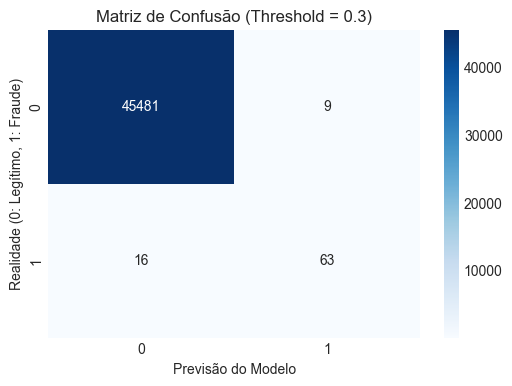

In [5]:
print("📉 Gerando métricas de negócio para a validação...")
val_preds_proba = model.predict_proba(X_val_processed)[:, 1]

# Threshold de 0.3 para priorizar a captura de fraudes (Recall)
threshold = 0.3
y_pred_binario = (val_preds_proba >= threshold).astype(int)

print("\nRelatório de Classificação (Foco no Recall - Classe 1):")
print(classification_report(y_val, y_pred_binario))

# Plota e salva a Matriz de Confusão
cm = confusion_matrix(y_val, y_pred_binario)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão (Threshold = {threshold})')
plt.ylabel('Realidade (0: Legítimo, 1: Fraude)')
plt.xlabel('Previsão do Modelo')
plt.savefig('matriz_confusao.png', bbox_inches='tight')
print("✅ Gráfico salvo: matriz_confusao.png")

### 5. Interpretabilidade (Explainable AI - SHAP)
Para evitar o comportamento de "Caixa-Preta" e atender às restrições regulatórias do edital, aplicaremos a Teoria dos Jogos (SHAP) para dissecar o processo de decisão do modelo.

📊 Gerando Análise SHAP (Isso pode levar alguns instantes)...
✅ Gráfico Global salvo: shap_summary.png
✅ Gráfico Local salvo: shap_local_fraude.png


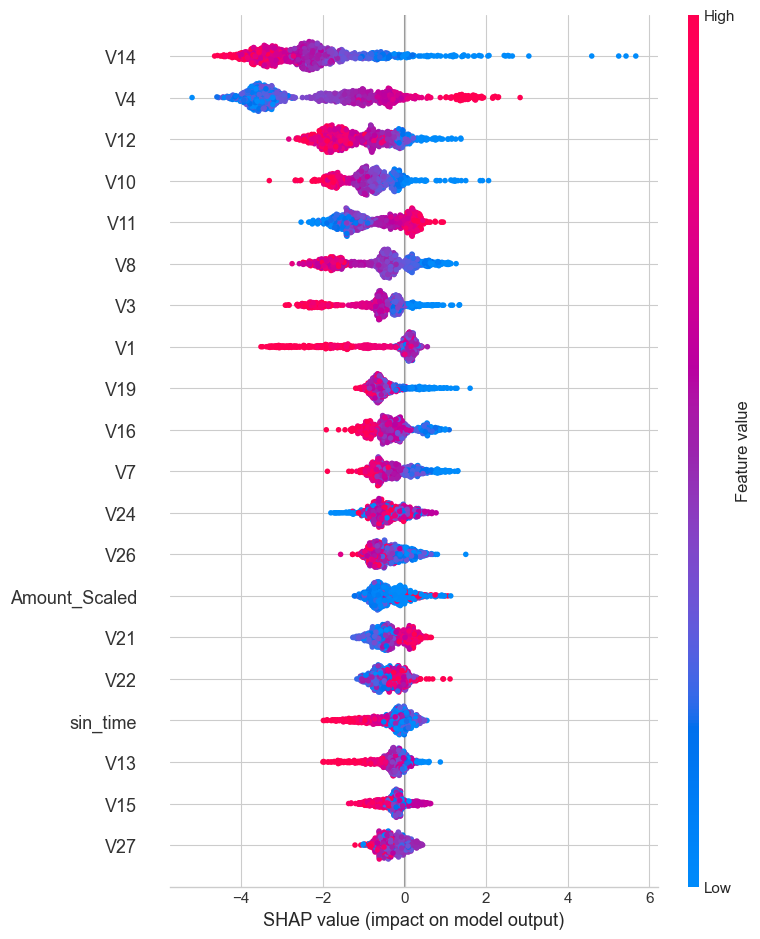

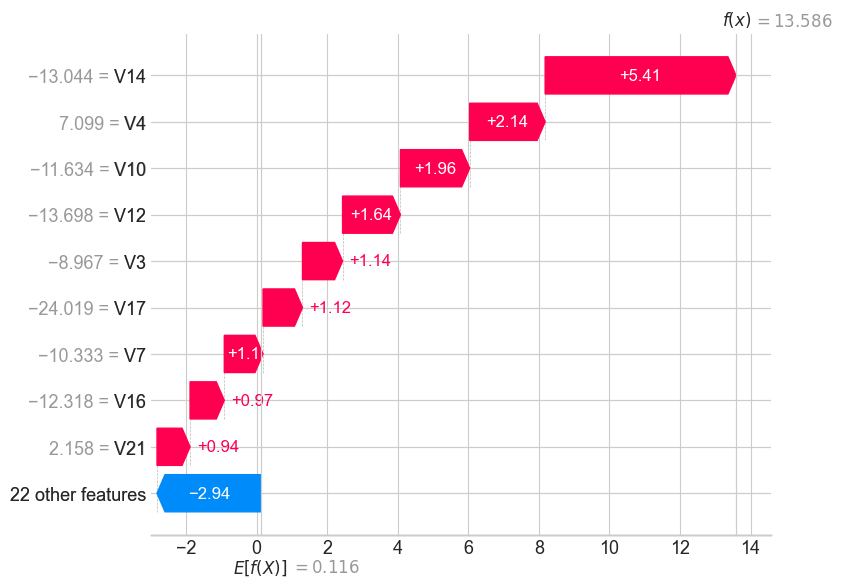

In [6]:
print("📊 Gerando Análise SHAP (Isso pode levar alguns instantes)...")
explainer = shap.TreeExplainer(model)

# 1. SHAP Global
X_val_sample = shap.sample(X_val_processed, 1000)
shap_values_global = explainer.shap_values(X_val_sample)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, X_val_sample, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ Gráfico Global salvo: shap_summary.png")

# 2. SHAP Local (A dissecção de uma fraude específica)
idx_fraude = y_val[(y_val == 1) & (y_pred_binario == 1)].index[0]
posicao_fraude = X_val_processed.index.get_loc(idx_fraude)

shap_values_local = explainer(X_val_processed)
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_local[posicao_fraude], show=False)
plt.savefig('shap_local_fraude.png', bbox_inches='tight')
print("✅ Gráfico Local salvo: shap_local_fraude.png")

### 6. Geração do Arquivo Kaggle (Submissão Oficial)

In [ ]:
print("🚀 Processando arquivo final para o Kaggle...")
# Aplica o MESMO scaler do treino no teste
X_test_processed = feature_engineering(df_test, scaler=scaler_treinado, is_train=False)
X_test_processed = X_test_processed[X_train_processed.columns]

# Prever probabilidades
test_preds = model.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_preds
})

submission.to_csv('submission_super_robusta.csv', index=False)
print("🎉 FINALIZADO! O arquivo 'submission_super_robusta.csv' está pronto na pasta.")

🚀 Processando arquivo final para o Kaggle...
🎉 FINALIZADO! O arquivo 'submission_super_robusta.csv' está pronto na sua pasta.
